In [3]:
#Import required Libraries
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = 'online_retail.csv'
df_data = pd.read_csv(data)

In [5]:
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Analysis

## Data Cleaning and Preparation

In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Get a statistical summary of the data

In [7]:
df_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
# check for the total sum of the null values in the column that they exist
df_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The above data indicates that there are 1454 empty data in the description label and 135080 in the customerid label.This is an indication that the number of features without a customerid which is the unique column is more than the description feature but far less than the overrall number of record. Dropping the records with missing values will probably have an minute effect on the performance of the trained model when feed with unseen data

In [9]:
df_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [10]:
# drop records that have missing values
df_data.dropna()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


The number of rows that will be left after droppping the missing records is 406829, which I think is a good reasonable amount of data to train the model for high predictiive accuracy

In [11]:
df_data = df_data.dropna()

In [12]:
df_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [13]:
# check for the existence of any features with null values
df_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [14]:
# country count
df_data['Country'].value_counts()

Country
United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45


In [15]:
# count of the classes of description
df_data['Description'].value_counts()

Description
WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
                                      ... 
ANTIQUE RASPBERRY FLOWER EARRINGS        1
WALL ART,ONLY ONE PERSON                 1
GOLD/AMBER DROP EARRINGS W LEAF          1
INCENSE BAZAAR PEACH                     1
PINK BAROQUE FLOCK CANDLE HOLDER         1
Name: count, Length: 3896, dtype: int64

### Feature Engineering

In [16]:
# convert datetime to integer timestamp
df_data['InvoiceDate'] = pd.to_datetime(df_data['InvoiceDate']).astype(int)/ 10**9

In [17]:
# drop country feature since it has little or no bearing on future price rate
df_data = df_data.drop(columns=['Description', 'Country'])

In [18]:
# drop customer id column
df_data = df_data.drop(columns=['CustomerID'])

In [19]:
# drop the stock code, invoice number, and invoice date features
df_data = df_data.drop(columns=['StockCode'])
df_data = df_data.drop(columns=['InvoiceNo'])

In [20]:
# get the UnitPrice series
unit_price = df_data['UnitPrice']

In [21]:
# convert the pandas dataframe data to numpy
nd_data = df_data.to_numpy()

In [22]:
nd_data

array([[6.00000000e+00, 1.29119196e+09, 2.55000000e+00],
       [6.00000000e+00, 1.29119196e+09, 3.39000000e+00],
       [8.00000000e+00, 1.29119196e+09, 2.75000000e+00],
       ...,
       [4.00000000e+00, 1.32343500e+09, 4.15000000e+00],
       [4.00000000e+00, 1.32343500e+09, 4.15000000e+00],
       [3.00000000e+00, 1.32343500e+09, 4.95000000e+00]])

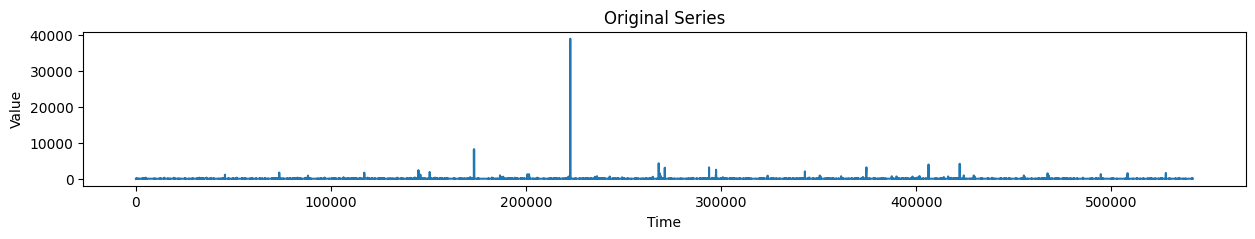

In [23]:
plt.figure(figsize=(15, 2))
plt.plot(unit_price)
plt.title('Original Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

A look at the time series graph shows that the series is a stationary one.

#### ADF Test - find the order differencing, d

In [24]:
adf_result = adfuller(unit_price)

In [25]:
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -123.084915
p-value: 0.000000


The null hypothesis of the ADF test is that the time series is stationary. So, since the p-value of the test is less than the significance level (0.05), I decided to reject the null hypothesis and infer that the time series is indeed stationary.

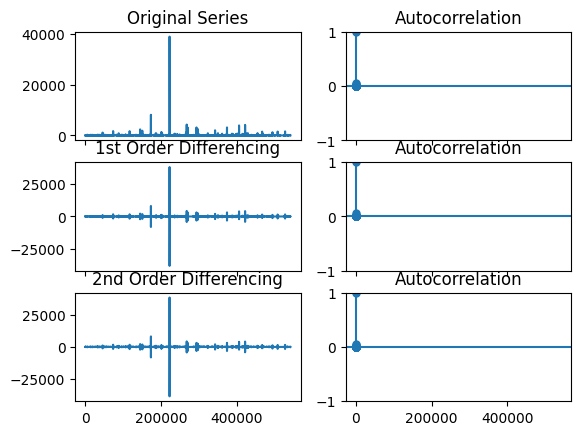

In [26]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(unit_price); axes[0, 0].set_title('Original Series')
plot_acf(unit_price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(unit_price.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(unit_price, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(unit_price.diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(unit_price, ax=axes[2, 1])

plt.show()

Get the ADF Statistics for each order differencing

In [27]:
print('ADF Statistic for 1st Order Differencing')
result = adfuller(unit_price)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(unit_price)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for 1st Order Differencing
ADF Statistic: -123.084915
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -123.084915
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


The order differencing, d, will be taken as 1 with the p-value indicating that it's stationary.

### Finding the order of the AutoRegressive term, p

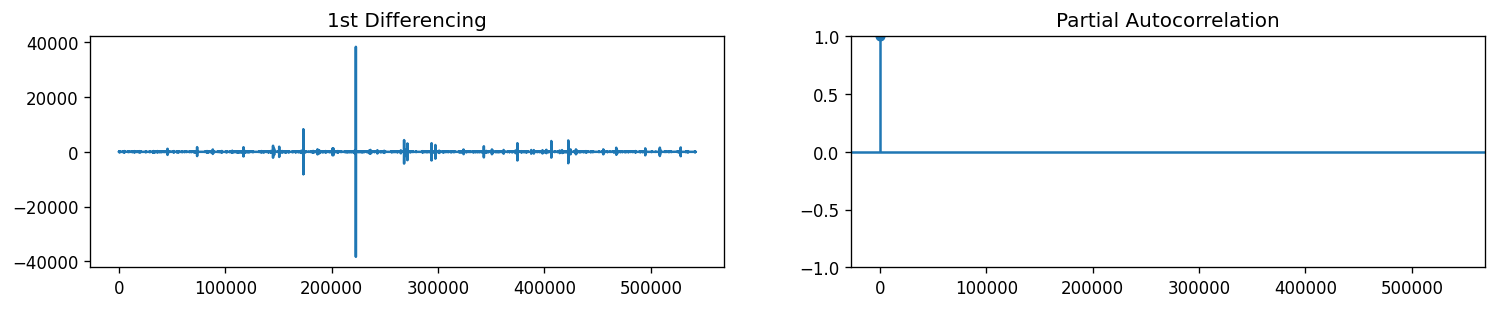

In [28]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(unit_price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(unit_price.diff(), ax=axes[1])

plt.show()

From the above graph the value of the AutoRegressive Term will be taken as 1 since it is the only point above the 0.0 mark

### Finding the order of the Moving Average term, q

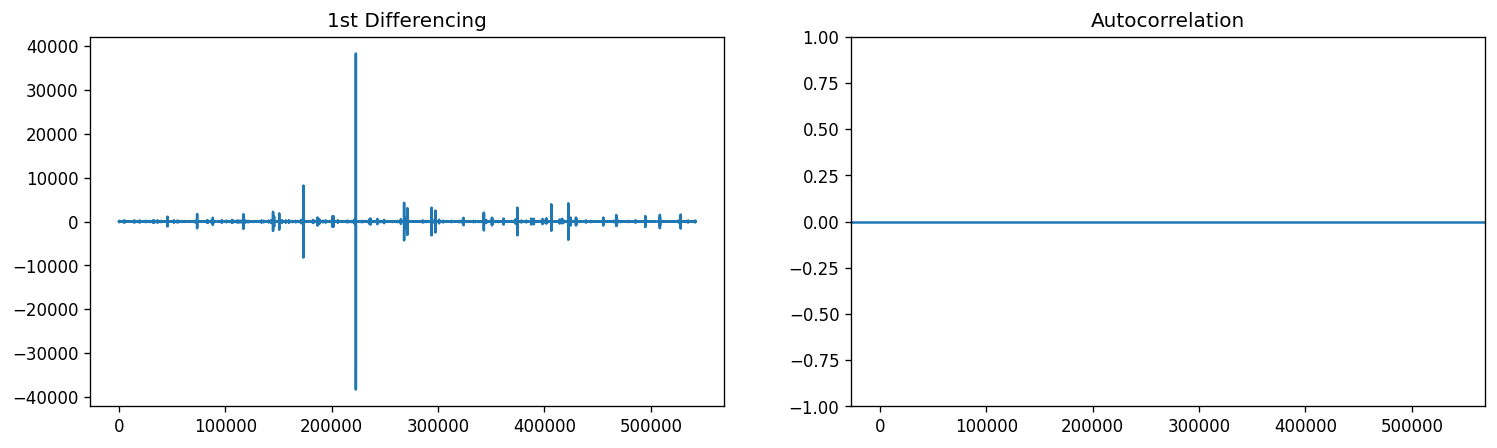

In [29]:
# ACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(unit_price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_acf(unit_price.diff(), ax=axes[1])

plt.show()

# Building the ARIMA Model

In [30]:
# spliting the data into training and testing set
train_size = 306829
unit_price_train, unit_price_test = unit_price[:train_size], unit_price[train_size:]

In [31]:
unit_price_test.count()

100000

In [32]:
model = ARIMA(unit_price_train, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              UnitPrice   No. Observations:               306829
Model:                 ARIMA(1, 1, 1)   Log Likelihood            -1772995.060
Date:                Fri, 30 Aug 2024   AIC                        3545996.119
Time:                        06:56:45   BIC                        3546028.021
Sample:                             0   HQIC                       3546005.337
                             - 306829                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0539      0.000    494.545      0.000       0.054       0.054
ma.L1         -1.0000   3.41e-05  -2.93e+04      0.000      -1.000      -1.000
sigma2      6117.9913      0.064   9.54e+04      0.0

# Evaluating the model

In [33]:
# Model Prediction
y_hat = model_fit.forecast(steps=24)

In [ ]:
mae_cv = list()
    
X_cv = []
Y_cv = []
for t in range(0, len(unit_price_test), 5):
    x_cv = np.hstack([unit_price_train, unit_price_test[:t]])
    y_cv = unit_price_test.index[t]
    X_cv.append(x_cv)
    Y_cv.append(y_cv)

#pool = mp.Pool(processes=mp.cpu_count()-4)
#y_hats = pool.map(wrapper_fit_arima, X_cv)        

mae_cv = []
for t in range(len(unit_price_test)):
    mae_cv.append(mean_absolute_error(Y_cv[t], y_hat[t]))
mean_mae = np.mean(mae_cv)

Looking the Mean Absolute Error (MAE), the ARIMA(1,1,1) model is has an average better performace on the test set.